In [19]:
import tensorflow as tf
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
mpl.rcParams['figure.dpi'] = 250

k562_path = '/content/k562_chrombpnet_wo_bias.h5'
gm12878_path = '/content/gm12878_chrombpnet_wo_bias.h5'
hepg2_path = '/content/hepg2_chrombpnet_wo_bias.h5'
h1esc_path = '/content/h1esc_chrombpnet_wo_bias.h5'

k562_bpnet = tf.keras.models.load_model(k562_path, compile=False)
gm12878_bpnet = tf.keras.models.load_model(gm12878_path, compile=False)
hepg2_bpnet = tf.keras.models.load_model(hepg2_path, compile=False)
h1esc_bpnet = tf.keras.models.load_model(h1esc_path, compile=False)

In [20]:
df = pd.read_csv('/content/processed_data_removed.txt')

# Extending Sequences to length 2114

In [ ]:
!pip install ucsc_genomes_downloader
from ucsc_genomes_downloader import Genome
hg19 = Genome(assembly="hg19")

In [ ]:
df = pd.read_csv(data_path, delimiter='\t')
df = df.rename(columns={'chr': 'chrom', 'start': 'chromStart', 'end': 'chromEnd'})
df = df.drop(['sequence'], axis=1)

a = []
b = []
for ind, row in df.iterrows():
    flank_len = (2114 - (row['chromEnd'] - row['chromStart']))//2
    a1 = row['chromEnd'] + flank_len
    b1 = row['chromStart'] - flank_len
    if a1 - b1 == 2113:
        b1 -= 1
    elif a1 - b1 == 2115:
        b1 += 1
    b.append(b1)
    a.append(a1)
df['chromEnd'] = a
df['chromStart'] = b

sequences = hg19.bed_to_sequence(df)
for i in range(len(sequences)):
    sequences[i] = sequences[i].upper()

df['Full_Sequence'] = sequences
df.to_csv('processed_data.txt', sep=',', header=True)
indices = []
for i, j in enumerate(sequences):
    if len(j) != 2114: indices.append(i)
df_removed = df.drop(indices)
df.to_csv('processed_data_removed.txt', sep=',', header=True)

# Shuffling DNA Sequences (getting negative sequences)

In [ ]:
import pandas as pd
import random

df = pd.read_csv('/content/processed_data.txt')
full_sequences = df['Full_Sequence']
shuffled_sequences = []
for i in range(len(full_sequences)):
    if type(full_sequences[i]) == str:
        shuffled_sequences.append(''.join(random.sample(full_sequences[i], len(full_sequences[i]))))
    else:
        shuffled_sequences.append(full_sequences[i])

for i in range(len(full_sequences)):
    assert type(full_sequences[i]) == type(shuffled_sequences[i])
    if type(full_sequences[i]) == str:
        assert full_sequences[i].count('A') == shuffled_sequences[i].count('A')
        assert full_sequences[i].count('C') == shuffled_sequences[i].count('C')
        assert full_sequences[i].count('G') == shuffled_sequences[i].count('G')
        assert full_sequences[i].count('T') == shuffled_sequences[i].count('T')

df['Shuffled_Sequence'] = shuffled_sequences
df.to_csv('processed_data_with_shuffled.txt', sep=',', header=True, index=False)

# Running chrombpnet

In [21]:
def preprocess_sequence(seq):
    letter2ind = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    sequence = []
    for i in range(2114): sequence.append(letter2ind[seq[i]])
    sequence = np.array(sequence)
    b = np.zeros((sequence.size, sequence.max() + 1))
    b[np.arange(sequence.size), sequence] = 1
    return b[None, :]

In [22]:
def plot_chrom_accessibility(k562_output, gm12878_output, hepg2_output, h1esc_output, shuffled=False):
    plt.plot(list(range(94)), k562_output[0][0, 453:547], "r-")
    plt.plot(list(range(94)), gm12878_output[0][0, 453:547], "g-")
    plt.plot(list(range(94)), hepg2_output[0][0, 453:547], "b-")
    plt.plot(list(range(94)), h1esc_output[0][0, 453:547], "y-")
    if shuffled: plt.title('Shuffled Sequence Chromatin Accessibility')
    else: plt.title('Chromatin Accessibility')

In [25]:
heatmap = np.zeros((4, 4))

for row_num, row in tqdm(df.iterrows(), total=df.shape[0]):
    curr_seq = row['Full_Sequence']
    if type(curr_seq) != str or 'N' in curr_seq: continue
    curr_seq = preprocess_sequence(curr_seq)
    cell_type = -1
    if round(row['GM12878_ENCLB441ZZZ']) == 1: cell_type = 0
    elif round(row['hESCT0_ENCLB449ZZZ']) == 1: cell_type = 1
    elif round(row['K562_ENCLB843GMH']) == 1: cell_type = 2
    else: cell_type = 3
    cell_type = int(cell_type)
    gm12878_output = float(sum(gm12878_bpnet(curr_seq)[0][0, 453:547]))/95
    h1esc_output = float(sum(h1esc_bpnet(curr_seq)[0][0, 453:547]))/95
    k562_output = float(sum(k562_bpnet(curr_seq)[0][0, 453:547]))/95
    hepg2_output = float(sum(hepg2_bpnet(curr_seq)[0][0, 453:547]))/95
    heatmap[0][cell_type] += gm12878_output
    heatmap[1][cell_type] += h1esc_output
    heatmap[2][cell_type] += k562_output
    heatmap[3][cell_type] += hepg2_output

100%|██████████| 47872/47872 [1:54:55<00:00,  6.94it/s]  


In [28]:
print(heatmap)

[[41535.20681845 39676.78747535 41172.41896816 40791.45262993]
 [ 3069.91086259  2701.49181372  3397.62562798  3026.02765639]
 [44193.50243868 43434.14533547 44968.43680034 44102.57616481]
 [78817.57628752 78126.39380943 78922.57673982 79601.31313862]]


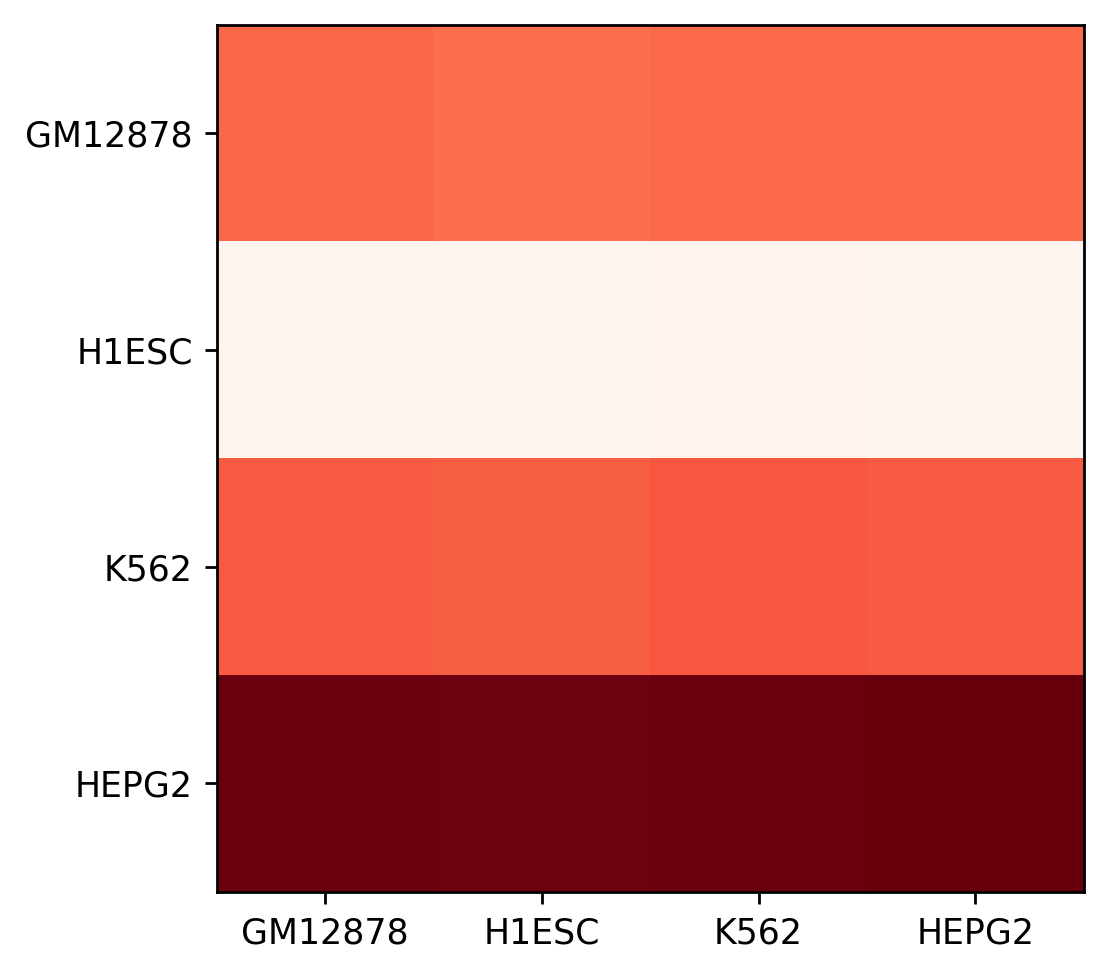

In [29]:
cell_type = ["GM12878", "H1ESC", "K562", "HEPG2"]

fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap=mpl.colormaps['Reds'])
ax.set_xticks(np.arange(len(cell_type)), labels=cell_type)
ax.set_yticks(np.arange(len(cell_type)), labels=cell_type)
fig.tight_layout()
plt.show()